In [34]:
import sympy
import symfem
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify
import dill
dill.settings["recurse"] = True

In [35]:
argyris_basis = dill.load(open("./calculations/argyris_basis", "rb"))

In [36]:
x, y, p, q = sympy.symbols("x y p q")
x1, x2, x3, x4, x5, x6 = sympy.symbols("x1:7")
y1, y2, y3, y4, y5, y6 = sympy.symbols("y1:7")

In [37]:
p2_element = symfem.create_element("triangle", "Lagrange", 2)
tmp = [p2_element.get_basis_function(j).as_sympy().subs(x, p).subs(y, q).expand() for j in range(6)]
p2_basis = sympy.Matrix(tmp)

In [38]:
x5 = (x1 + x3) / 2
y5 = (y1 + y3) / 2

x6 = (x1 + x2) / 2
y6 = (y1 + y2) / 2

X = p2_basis[0]*x1 + p2_basis[1]*x2 + p2_basis[2]*x3 + \
    p2_basis[3]*x4 + p2_basis[4]*x5 + p2_basis[5]*x6

Y = p2_basis[0]*y1 + p2_basis[1]*y2 + p2_basis[2]*y3 + \
    p2_basis[3]*y4 + p2_basis[4]*y5 + p2_basis[5]*y6

X = X.expand()
Y = Y.expand()

## My basis

In [102]:
monomial_basis = sympy.Matrix([
    1,
    x,
    x**2,
    x**3,
    y,
    y**2,
    y**3,
    x*y,
    x*y**2,
    x**2*y
])

In [141]:
V = sympy.zeros(10, 10)
s = sympy.symbols("s")
L_2 = 6*s**2 - 6*s + 1

from sympy import Rational as R
def l2(f):
    integrant = L_2 * f.subs({x: 0, y: s})
    return sympy.integrate(integrant, (s, 0, 1))

def l3(f):
    integrant = L_2 * f.subs({x: s, y: 0})
    return sympy.integrate(integrant, (s, 0, 1)) 

for i, basis in enumerate(monomial_basis):
    
    V[i, 0] = basis.subs({x: 0, y: 0})
    V[i, 1] = basis.subs({x: 1, y: 0})
    V[i, 2] = basis.subs({x: 0, y: 1})

    # edge 1
    V[i, 3] = basis.subs({x: 0, y: R(1,3)})
    V[i, 4] = basis.subs({x: 0, y: R(2,3)})

    # edge 2
    V[i, 5] = basis.subs({x: R(1,3), y: 0})
    V[i, 6] = basis.subs({x: R(2,3), y: 0})

    # center of mass
    V[i, 7] = basis.subs({x: R(1,3), y: R(1,3)})

    V[i, 8] = basis.subs(y, 1-x).diff(x).subs({x: 0})
    V[i, 9] = basis.subs(y, 1-x).diff(x).subs({x: 1})

In [208]:
new_basis = V.inv() @ monomial_basis

points = np.array([
    [1, 1],
    [4, 1],
    [1.5, 3],
])

In [209]:
X = points[0, 0]*new_basis[0] + points[1, 0]*new_basis[1] + \
    points[2, 0]*new_basis[2] + \
    (1/3*points[0, 0]+2/3*points[2, 0])*new_basis[3] + \
    (2/3*points[0, 0]+1/3*points[2, 0])*new_basis[4] + \
    (1/3*points[0, 0]+2/3*points[1, 0])*new_basis[5] + \
    (2/3*points[0, 0]+1/3*points[1, 0])*new_basis[6] + \
    points[:3, 0].mean()*new_basis[7] + \
    1*new_basis[8] + 0*new_basis[9]

Y = points[0, 1]*new_basis[0] + points[1, 1]*new_basis[1] + \
    points[2, 1]*new_basis[2] + \
    (1/3*points[0, 1]+2/3*points[2, 1])*new_basis[3] + \
    (2/3*points[0, 1]+1/3*points[2, 1])*new_basis[4] + \
    (1/3*points[0, 1]+2/3*points[1, 1])*new_basis[5] + \
    (2/3*points[0, 1]+1/3*points[1, 1])*new_basis[6] + \
    points[:3, 1].mean()*new_basis[7] + \
    0*new_basis[8] + -1*new_basis[9]

In [213]:
tt = np.linspace(0, 1, 100)
e1_x = sympy.lambdify([x, y], X)(tt, 1-tt)
e1_y = sympy.lambdify([x, y], Y)(tt, 1-tt)

e2_x = sympy.lambdify([x, y], X)(0, tt)
e2_y = sympy.lambdify([x, y], Y)(0, tt)

e3_x = sympy.lambdify([x, y], X)(tt, 0)
e3_y = sympy.lambdify([x, y], Y)(tt, 00)

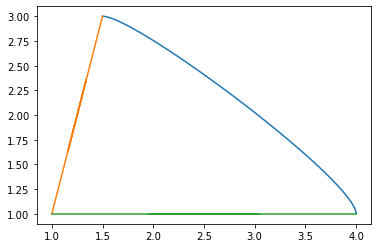

In [215]:
plt.subplots()
plt.plot(e1_x, e1_y)
plt.plot(e2_x, e2_y)
plt.plot(e3_x, e3_y)

In [41]:
F = sympy.Matrix([X, Y]).expand()
J_ = F.jacobian([p, q])

### Plot curved edges

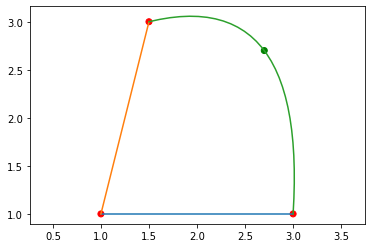

In [43]:
t = np.linspace(0, 1, 30)
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], c=["r", "r", "r", "g"])

xs = x1, x2, x3, x4, x5, x6
ys = y1, y2, y3, y4, y5, y6

curve_x = lambdify((p, q, *xs[:4], *ys[:4]), X)(t, 0, *points[:4, 0], *points[:4, 1])
curve_y = lambdify((p, q, *xs[:4], *ys[:4]), Y)(t, 0, *points[:4, 0], *points[:4, 1])
ax.plot(curve_x, curve_y)

curve_x = lambdify((p, q, *xs[:4], *ys[:4]), X)(0, t, *points[:4, 0], *points[:4, 1])
curve_y = lambdify((p, q, *xs[:4], *ys[:4]), Y)(0, t, *points[:4, 0], *points[:4, 1])
ax.plot(curve_x, curve_y)

curve_x = lambdify((p, q, *xs[:4], *ys[:4]), X)(t, 1-t, *points[:4, 0], *points[:4, 1])
curve_y = lambdify((p, q, *xs[:4], *ys[:4]), Y)(t, 1-t, *points[:4, 0], *points[:4, 1])
ax.plot(curve_x, curve_y)

ax.axis("equal")
plt.show()

### Get Jacobian matrix values

In [507]:
tx, ty = np.meshgrid(t, t, indexing="ij")

mask = (ty <= (1 - tx))
tx = tx[mask]
ty = ty[mask]

J_numeric = lambdify((p, q, *xs[:4], *ys[:4]), J_)(tx, ty, *points[:4, 0], *points[:4, 1])
J_numeric = J_numeric.transpose(2, 0, 1)
J_det = np.linalg.det(J_numeric)
print(J_det.min())

4.0


### Plot filled triangle

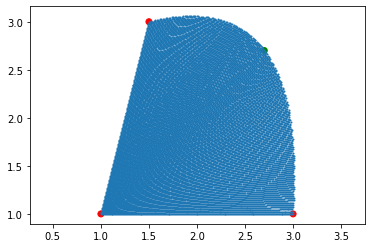

In [509]:
t = np.linspace(0, 1, 200)
%matplotlib inline
fig, ax = plt.subplots()

xs = x1, x2, x3, x4, x5, x6
ys = y1, y2, y3, y4, y5, y6

tx, ty = np.meshgrid(t, t, indexing="ij")

mask = (ty <= (1 - tx))
tx = tx[mask]
ty = ty[mask]

curve_x = lambdify((p, q, *xs[:4], *ys[:4]), X)(tx, ty, *points[:4, 0], *points[:4, 1])
curve_y = lambdify((p, q, *xs[:4], *ys[:4]), Y)(tx, ty, *points[:4, 0], *points[:4, 1])

ax.scatter(points[:, 0], points[:, 1], 
           c=["r", "r", "r", "g"])


ax.scatter(curve_x, curve_y, s=1)
ax.axis("equal")
plt.show()

### Plot basis functions

In [510]:
t = np.linspace(0, 1, 50)
tx, ty = np.meshgrid(t, t, indexing="ij")

mask = (ty <= 1 - tx)
tx = tx[mask]
ty = ty[mask]

xs = x1, x2, x3, x4, x5, x6
ys = y1, y2, y3, y4, y5, y6

phisical_x = lambdify((p, q, *xs[:4], *ys[:4]), X)(tx, ty, *points[:4, 0], *points[:4, 1])
phisical_y = lambdify((p, q, *xs[:4], *ys[:4]), Y)(tx, ty, *points[:4, 0], *points[:4, 1])
phisical_z = lambdify((p, q), p2_basis[0])(tx, ty)
phisical_J = lambdify((p, q, *xs[:4], *ys[:4]), J_.det())(tx, ty, *points[:4, 0], *points[:4, 1])

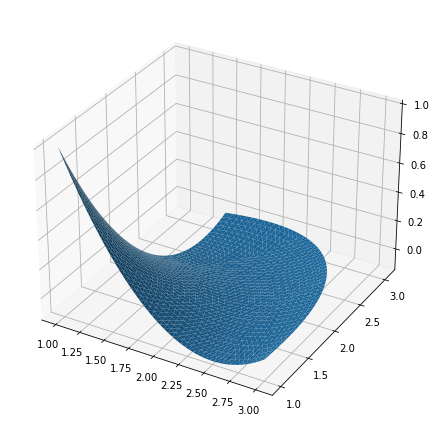

In [511]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection="3d"))
ax.plot_trisurf(phisical_x, phisical_y, phisical_z)
fig.tight_layout()
plt.show()

# Argyris basis on p2 isop element

In [539]:
from sympy import Rational as R

x, y, x_1, y_1, x_2, y_2, x_3, y_3 = sympy.symbols("x y x1 y1 x2 y2 x3 y3")

rotation_matrix = sympy.Matrix(
    [
        [+R(0), +R(1)],
        [-R(1), +R(0)]
    ]
)

t1_hat = sympy.Matrix([-R(1), +R(1)]) / sympy.sqrt(2)
t2_hat = sympy.Matrix([+R(0), +R(1)])
t3_hat = sympy.Matrix([+R(1), +R(0)])

n1_hat = rotation_matrix @ t1_hat
n2_hat = rotation_matrix @ t2_hat
n3_hat = rotation_matrix @ t3_hat

G1_hat = n1_hat.row_join(t1_hat).T
G2_hat = n2_hat.row_join(t2_hat).T
G3_hat = n3_hat.row_join(t3_hat).T

l1 = ((x_3 - x_2) ** 2 + (y_3 - y_2) ** 2) ** R(1, 2)
l2 = ((x_3 - x_1) ** 2 + (y_3 - y_1) ** 2) ** R(1, 2)
l3 = ((x_2 - x_1) ** 2 + (y_2 - y_1) ** 2) ** R(1, 2)

t1 = sympy.Matrix([x_3 - x_2, y_3 - y_2]) / l1
t2 = sympy.Matrix([x_3 - x_1, y_3 - y_1]) / l2
t3 = sympy.Matrix([x_2 - x_1, y_2 - y_1]) / l3

n1 = rotation_matrix @ t1
n2 = rotation_matrix @ t2
n3 = rotation_matrix @ t3

tau_1 = sympy.Matrix([t1[0] ** 2, 2 * t1[0] * t1[1], t1[1] ** 2])
tau_2 = sympy.Matrix([t2[0] ** 2, 2 * t2[0] * t2[1], t2[1] ** 2])
tau_3 = sympy.Matrix([t3[0] ** 2, 2 * t3[0] * t3[1], t3[1] ** 2])

J = J_.inv()

THETA = sympy.Matrix(
    [
        [J[0, 0]**2, 2*J[0, 0]*J[1, 0], J[1, 0]**2],
        [J[0, 1]*J[0, 0], J[0, 1]*J[1, 0] + J[0, 0]*J[1, 1], J[1, 0]*J[1, 1]],
        [J[0, 1]**2, 2*J[0, 1]*J[1, 1], J[1, 1]**2],
    ]
)

G1 = n1.row_join(t1).T
G2 = n2.row_join(t2).T
G3 = n3.row_join(t3).T

B1 = G1_hat @ J.inv().T @ G1.T
B2 = G2_hat @ J.inv().T @ G2.T
B3 = G3_hat @ J.inv().T @ G3.T

In [513]:
kv = {
    x1: points[0, 0],
    x2: points[1, 0],
    x3: points[2, 0],
    x4: points[3, 0],    
    y1: points[0, 1],
    y2: points[1, 1],
    y3: points[2, 1],
    y4: points[3, 1],
}

In [514]:
V_c = sympy.diag(
    1,
    J.inv().T.subs(kv).subs({p: 0, q: 0}),
    THETA.subs(kv).subs({p: 0, q: 0}).inv(),
    1,
    J.inv().T.subs(kv).subs({p: 1, q: 0}),
    THETA.subs(kv).subs({p: 1, q: 0}),
    1,
    J.inv().T.subs(kv).subs({p: 0, q: 1}),
    THETA.subs(kv).subs({p: 0, q: 1}).inv(),
    B1.subs(kv).subs({p: 0.5, q: 0.5}),
    B2.subs(kv).subs({p: 0.0, q: 0.5}),
    B3.subs(kv).subs({p: 0.5, q: 0.5}),
)

In [515]:
E = np.zeros((21, 24), dtype=int)
for i in range(21):
    for j in range(24):
        if (i <= 18) and (j <= 18) and (i == j):
            E[i][j] = 1
        elif (i == 19) and (j == 20):
            E[i][j] = 1
        elif (i == 20) and (j == 22):
            E[i][j] = 1
E = sympy.Matrix(E)

In [516]:
D = sympy.Matrix(
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            -R(15, 8) / l1,
            -R(7, 16) * t1[0],
            -R(7, 16) * t1[1],
            -l1 / 32 * tau_1[0],
            -l1 / 32 * tau_1[1],
            -l1 / 32 * tau_1[2],
            +R(15, 8) / l1,
            -R(7, 16) * t1[0],
            -R(7, 16) * t1[1],
            +l1 / 32 * tau_1[0],
            +l1 / 32 * tau_1[1],
            +l1 / 32 * tau_1[2],
            0,
            0,
            0,
        ],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [
            -R(15, 8) / l2,
            -R(7, 16) * t2[0],
            -R(7, 16) * t2[1],
            -l2 / 32 * tau_2[0],
            -l2 / 32 * tau_2[1],
            -l2 / 32 * tau_2[2],
            0,
            0,
            0,
            0,
            0,
            0,
            +R(15, 8) / l2,
            -R(7, 16) * t2[0],
            -R(7, 16) * t2[1],
            +l2 / 32 * tau_2[0],
            +l2 / 32 * tau_2[1],
            +l2 / 32 * tau_2[2],
            0,
            0,
            0,
        ],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [
            -R(15, 8) / l3,
            -R(7, 16) * t3[0],
            -R(7, 16) * t3[1],
            -l3 / 32 * tau_3[0],
            -l3 / 32 * tau_3[1],
            -l3 / 32 * tau_3[2],
            +R(15, 8) / l3,
            -R(7, 16) * t3[0],
            -R(7, 16) * t3[1],
            +l3 / 32 * tau_3[0],
            +l3 / 32 * tau_3[1],
            +l3 / 32 * tau_3[2],
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
        ],
    ]
).subs(kv)

In [517]:
V = E @ V_c @ D
M = V.T

In [518]:
# bs = argyris_basis.diff(x)*J[0, 0] + argyris_basis.diff(y)*J[1, 0]
# bs = bs.subs(kv).subs({p: x, q: y})
bs = argyris_basis
physical_basis = sympy.lambdify([x, y], M@bs)

In [519]:
grid = np.linspace(0, 1, 30)
grid_x, grid_y = np.meshgrid(grid, grid, indexing="ij")
mask = (grid_y <= 1 - grid_x)
reference_x = grid_x[mask]
reference_y = grid_y[mask]

In [520]:
physical_x = sympy.lambdify([p, q], X.subs(kv))(reference_x, reference_y)
physical_y = sympy.lambdify([p, q], Y.subs(kv))(reference_x, reference_y)

In [530]:
iv = np.array([
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    1, 0, 0, 0, 0, 0,
    0, 0, 0
])

In [531]:
physical_z = iv@physical_basis(reference_x, reference_y)[:, 0]

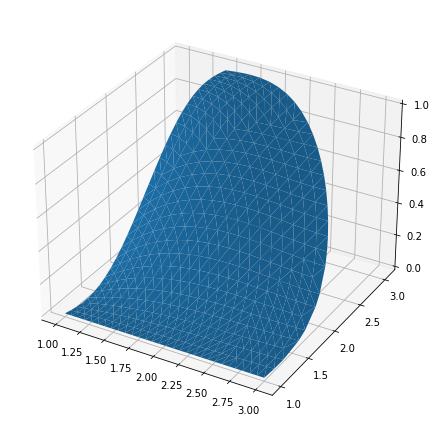

In [532]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection="3d"))
ax.plot_trisurf(physical_x, physical_y, physical_z)
fig.tight_layout()
plt.show()